In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("luluw8071/brain-tumor-mri-datasets")

print("Path to dataset files:", path)

100%|██████████| 181M/181M [00:01<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/luluw8071/brain-tumor-mri-datasets/versions/1


In [4]:
!cp -r /root/.cache/kagglehub/datasets/luluw8071/brain-tumor-mri-datasets/versions/1 /content/data

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
os.listdir('data/Brain_Tumor_Datasets')

['test', 'train']

In [ ]:
def get_df(path):
  labels=[]
  images_path=[]
  for i in os.listdir(path):

    for j in os.listdir(os.path.join(path,i)):
      images_path.append(os.path.join(path,i,j))
      labels.append(i)

  return images_path,labels




In [ ]:
images,labels=get_df('data/Brain_Tumor_Datasets/train')
train_df=pd.DataFrame({'path':images,'label':labels})


In [ ]:
images,labels=get_df('data/Brain_Tumor_Datasets/test')
test_df=pd.DataFrame({'path':images,'label':labels})


In [ ]:
train_df,val_df=train_test_split(train_df,test_size=0.2,random_state=42)

In [ ]:
train = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    class_mode='binary'
)

Found 5609 validated image filenames belonging to 2 classes.
Found 1403 validated image filenames belonging to 2 classes.
Found 1752 validated image filenames belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False,input_shape=(224,224,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)

preds=Dense(1,activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
checkpoints = ModelCheckpoint("/content/model.keras",save_best_only=True,)
early_stopping = EarlyStopping(patience=10,restore_best_weights=True)
rd=ReduceLROnPlateau(patience=10)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy',AUC(name='auc')])

In [ ]:
model.fit(train,batch_size=16,epochs=50,validation_data=val,callbacks=[checkpoints,early_stopping,rd])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 265ms/step - accuracy: 0.8963 - auc: 0.9436 - loss: 0.2841 - val_accuracy: 0.9729 - val_auc: 0.9973 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9738 - auc: 0.9966 - loss: 0.0695 - val_accuracy: 0.9758 - val_auc: 0.9988 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9844 - auc: 0.9980 - loss: 0.0496 - val_accuracy: 0.9786 - val_auc: 0.9991 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9859 - auc: 0.9982 - loss: 0.0477 - val_accuracy: 0.9879 - val_auc: 0.9995 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9931 - auc: 0.9996 - loss: 0.0245 - val_accuracy: 0.9907 - val_auc: 0.9987 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.9901 - auc: 

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epoch')

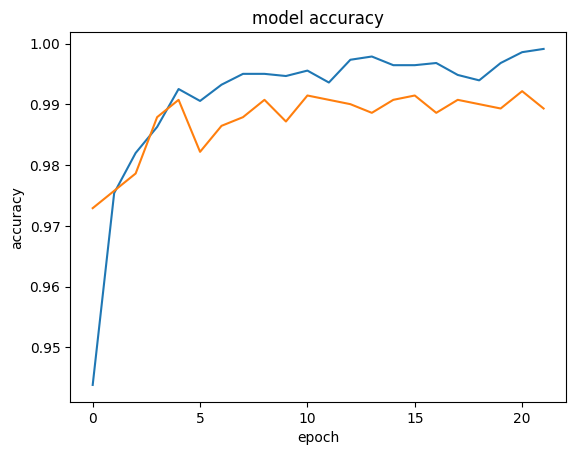

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

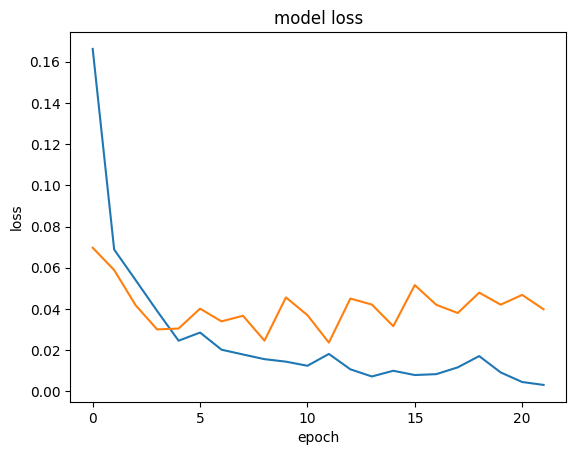

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
model.evaluate(test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.9916 - auc: 0.4276 - loss: 0.0384


[0.03277771919965744, 0.9920091032981873, 0.9976854920387268]

In [ ]:
proba=model.predict(test).flatten()

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step 


In [ ]:
ypreds=np.where(proba>0.5,1,0)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test.classes, proba)
roc_auc = auc(fpr, tpr)
print("Test AUC:", roc_auc)

Test AUC: 0.9986928897243615


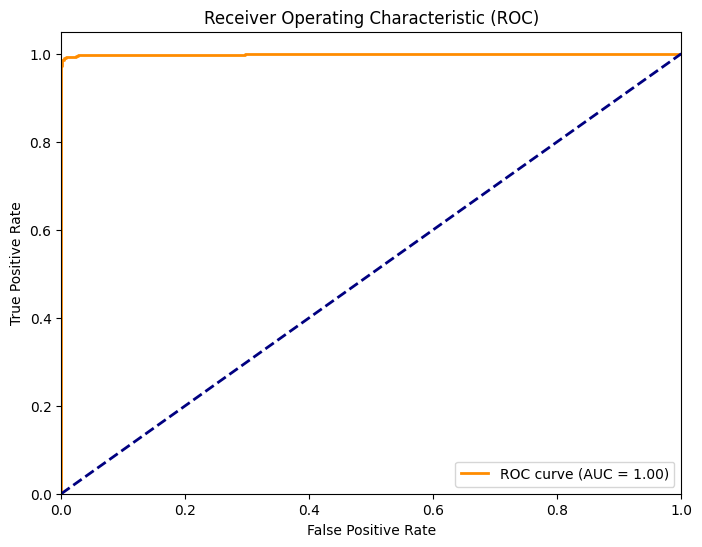

<Figure size 640x480 with 0 Axes>

In [ ]:


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_curve.png')

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [ ]:
result={
    'accuracy':accuracy_score(test.classes,ypreds),
    'precision':precision_score(test.classes,ypreds),
    'recall':recall_score(test.classes,ypreds),
    'f1_score':f1_score(test.classes,ypreds)
}

In [ ]:
result

{'accuracy': 0.9920091324200914,
 'precision': 0.997078870496592,
 'recall': 0.9893719806763285,
 'f1_score': 0.9932104752667313}

In [ ]:
import json
with open('result.json','w') as f:
  json.dump(result,f)

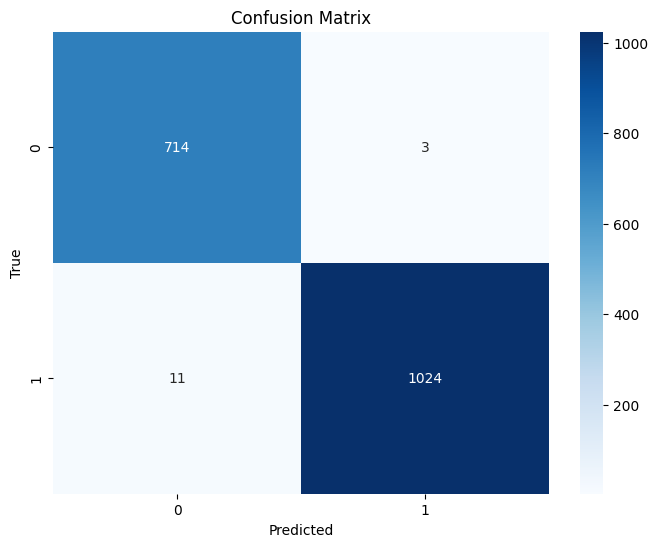

In [ ]:
import seaborn as sns
cm = confusion_matrix(test.classes, ypreds)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

In [1]:
from tensorflow.keras.models import load_model

In [8]:
model=load_model('model.keras')

In [ ]:
model.evaluate(test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.9916 - auc: 0.4276 - loss: 0.0384


[0.03277771919965744, 0.9920091032981873, 0.9976854920387268]

In [9]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np

img_path = "/content/data/Brain_Tumor_Datasets/test/no/31 no.jpg"
img =load_img(img_path, target_size=(224,224))
x =img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)
pred_label = 1 if pred > 0.5 else 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


In [10]:
pred_label

0

In [ ]:
test.class_indices

{'no': 0, 'yes': 1}